# Predicting Amazon review score based only on the text
 
In this exercise I will use a Logistic regression model to explore if we can predict the rating of a Book review in Amazon based exclusively on the text of the review.
 
I will begin importing the libraries necessary to perform this exercise.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pymongo import MongoClient

import re

import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

client = MongoClient()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ordovas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Now we load a fraction of the dataset and visualize the head of the dataset that we obtained.

In [2]:
db = client.get_database("amazon")
# Define an alias for the books dataset
books =db.books
# Obtain a random sample from the dataset, selecting only a few records 
# (we will use only overall and reviewTest, but I will load a few more just in case I
# want to play with more info...)
res = list(books.aggregate([
    { "$sample": { "size": 60000 }}
    ,{ "$project": {"id": "$_id", "_id": 0, "overall": 1, "reviewText": 1,"summary":1,"reviewerName":1}} 
]))
# Converting to pandas DataFrame
df=pd.DataFrame(res)

In [3]:
df.head()

,overall,reviewerName,reviewText,summary,id
0,5,DragonKing,Lord of the Rings is by far one of the best se...,Lord of the Rings...need I say more?,6033ab79f7ccad4a92f2fdb6
1,5,Joseph De Maio,"Despite the some time ""sing-song"" translation,...",Compelling translatio9n,6033ab9af7ccad4a92f9a1d2
2,5,Joanna M,I'm not usually a big fan of war stories that ...,Fabulously timeless!,6033ab96f7ccad4a92f8d499
3,5,Barbara Kornbluth,Once again Gabriel Allen shines as the hero of...,Another hit for Daniel Silvia,6033ab92f7ccad4a92f80923
4,5,Ed Deisley,a great book describing a very brutal war that...,a long way gone,6033ab7ef7ccad4a92f40697


I wil now drop the rows with NaN values in the `reviewText` column.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   overall       60000 non-null  int64 
 1   reviewerName  59996 non-null  object
 2   reviewText    59992 non-null  object
 3   summary       59991 non-null  object
 4   id            60000 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.3+ MB


In [5]:
df=df.dropna(subset=['reviewText'])

Let's check that everything is fine...

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59992 entries, 0 to 59999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   overall       59992 non-null  int64 
 1   reviewerName  59988 non-null  object
 2   reviewText    59992 non-null  object
 3   summary       59983 non-null  object
 4   id            59992 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.7+ MB


OK, so now I will examine the `overall` column, that is the target feature.
 
There are far more reviews with high ratings than with low scores, so there is no balance. To solve this, later on I will weight the clases instead of selecting now the exact number of reviews for each rating.

In [7]:
df["overall"].value_counts()

5    37852
4    12129
3     5443
2     2524
1     2044
Name: overall, dtype: int64

## Preprocessing: TF-IDF
 
I will create TF-IFD vectors for each review. TF-IDF measures the frequency of each word inside a review and compares it with the number of documents where this word appears. 
 
To begin with I will clean the review text ignoring stop words and words with less than 4 letters, as they will likely not contain much information.

In [8]:
def cleaning_review(texts):
    #Remove numbers, punctuation and lowercase everything
    res=re.sub("[^A-Za-z]+", " ", texts.lower()) 
    #Remove words with less than 4 letters
    res=re.sub(r'\b\w{1,3}\b', "", res) 
    #Remove rest of stop words
    for stopword in stopwords.words('english'): 
        sw=stopword.replace("'","")
        res=res.replace(f" {sw} "," ")
    return res



Now I will create a feature with the "cleaned" text named `review_clean`

In [9]:
df["review_clean"]=df["reviewText"]
df["review_clean"]=df["review_clean"].apply(cleaning_review)
df=df.reset_index()

And then we can now create the TF-IDF vectors for each review using `TfidfVectorizer` from  `sklearn`. We ignore words that don't appear in at least 5 reviews.

In [10]:
v = TfidfVectorizer(min_df=5)
x = v.fit_transform(df['review_clean']).toarray()
df_tfidf = pd.DataFrame(x, columns=v.get_feature_names())

Just for curiosity, let's check how many features/words the TF-IDF vectors have...

In [11]:
len(v.get_feature_names())

22576

## Logistic Regression: Predicting the scores based on the TF-IDF vectors
 
First of all, we need to split the dataset into train and test samples. I will choose 85% of the sample to train and 15% to test.
 
The TD-IFD vectors are the features used to predict the target, that is the `overall` column that stores the numeric ratings.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df_tfidf, df["overall"], test_size=0.15, random_state=42)

In [13]:
len(y_train),len(y_test)

(50993, 8999)

Now it's time to use the Logistic Regression model to predict the scores of the reviews.
 
We will activate `class_weight="balanced"`, as the classes (scores) are not balanced, so if we do not weigh the classes the fit will be biased towards high ratings (most populated classes).
 
This is just a very simple approach, without fine tuning anything. This is just an exercise for learning purposes.

In [14]:
clf = LogisticRegression(random_state=0,class_weight="balanced").fit(X_train, y_train)

/home/ordovas/anaconda3/envs/ironhack/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


That's it? Well, now we need to check the performance of this model...

Let's check the score of the classification model for the train and test samples

In [15]:
sc_train=clf.score(X_train, y_train)
sc_test=clf.score(X_test, y_test)
print(f"Train sample classification score: {round(sc_train,2)}")
print(f"Test sample classification score: {round(sc_test,2)}")

Train sample classification score: 0.7
Test sample classification score: 0.57


This seems just OK, but let's check an histogram to see the accuracy of the predictions by plotting the true score minus the predicted score.

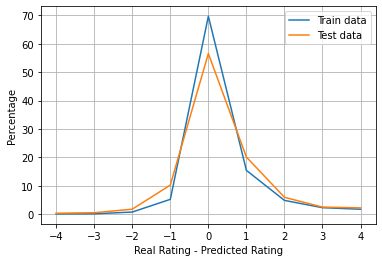

In [16]:
counts, bins = np.histogram(y_train-clf.predict(X_train),bins=np.arange(-4,6))
plt.plot(bins[:-1],counts*100/sum(counts),label="Train data")
plt.grid()
counts, bins = np.histogram(y_test-clf.predict(X_test),bins=np.arange(-4,6))
plt.plot(bins[:-1],counts*100/sum(counts),label="Test data")
plt.xlabel("Real Rating - Predicted Rating")
plt.ylabel("Percentage")
plt.legend();

Well, this simple model seems not to be very wrong! Let's quantify this with the confusion matrices as well.

In [17]:
confusion_matrix(y_train,clf.predict(X_train))

array([[ 1598,    44,    22,    12,    35],
       [   95,  1883,   100,    30,    41],
       [  220,   379,  3250,   458,   317],
       [  329,   426,  1299,  6217,  2050],
       [  879,   824,  1819,  6081, 22585]])

In [18]:
confusion_matrix(y_test,clf.predict(X_test))

array([[ 146,   94,   48,   17,   28],
       [  89,  133,  100,   26,   27],
       [  77,  148,  307,  205,   82],
       [  58,  106,  354,  769,  521],
       [ 198,  165,  350, 1217, 3734]])

And normalized to the true scores.

Train subsample:


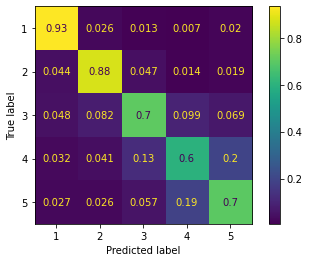

Test subsample:


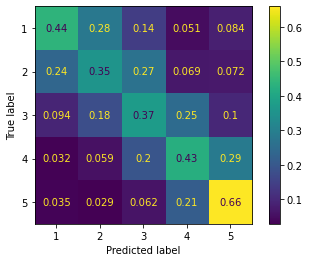

In [19]:
print("Train subsample:")
plot_confusion_matrix(clf, X_train, y_train,cmap="viridis",normalize="true") 
plt.show();
print("Test subsample:")
plot_confusion_matrix(clf, X_test, y_test,cmap="viridis",normalize="true")
plt.show();

The diagonal indicates that the Logistic Model predicts reasonably well the score of the review for this simple approach.

## Undersanding the Logistic Regression: How it is pedicted

I will create a DataFrame with the coefficients of each score to understand how the features (words) contributes to each class.

In [20]:
model=pd.DataFrame(clf.coef_,columns=X_train.columns)
model=model.T
model.columns=["1","2","3","4","5"]
model.head(20)

,1,2,3,4,5
aaron,0.093975,-0.157393,-0.182587,0.017450,0.228556
aback,0.086389,-0.247802,0.191209,-0.040057,0.010260
abandon,0.703385,0.041428,-0.335539,-0.282611,-0.126663
abandoned,2.699434,0.302078,-1.243608,-0.761792,-0.996111
abandoning,0.006603,-0.513907,0.424125,0.143396,-0.060217
abandonment,-0.221831,0.423298,-0.027310,-0.167869,-0.006289
abandons,-0.180794,0.362356,-0.183145,0.019487,-0.017904
abarat,-0.034610,-0.063897,-0.109407,-0.193140,0.401053
abbey,-0.742931,0.091508,-0.102994,0.381441,0.372975
abbot,-0.016100,-0.020736,0.013422,0.025232,-0.001818


For the highest score, the words that are directly correlated and contributes the most are words as "excellent", "great", "love", "fantastic", "amazing"...

In [21]:
model["5"].sort_values(ascending=False).head(20)

highly         4.918118
love           4.399495
excellent      4.202910
amazing        4.013397
awesome        3.951146
wonderful      3.757234
great          3.560739
loved          3.421101
brilliant      3.186792
beautiful      3.104279
must           2.929138
beautifully    2.785699
fascinating    2.770337
wait           2.715119
outstanding    2.700465
perfect        2.697543
thank          2.666832
every          2.541793
heart          2.535497
fantastic      2.479047
Name: 5, dtype: float64

So, for the lowest score, it is not strange that the words that are directly correlated and contribute the most are words such as "terrible","trash" or "boring".

In [22]:
model["1"].sort_values(ascending=False).head(20)

waste             4.978862
ridiculous        4.933624
wasted            4.650113
awful             4.451190
terrible          4.094857
horrible          4.079578
nothing           3.809138
boring            3.771562
even              3.705494
poorly            3.700529
worst             3.650589
money             3.628326
insult            3.359781
return            3.294963
total             3.227977
shame             3.123497
refund            3.055491
disappointment    3.055173
threw             2.984481
pointless         2.946969
Name: 1, dtype: float64

With respect to the intermediate scores, the words that define these reviews are related to texts that show good and bad aspects of the product, so words like "however" or "unfortunately" are weighted high, as well as "okay","somewhat" and "alright".

In [23]:
model["3"].sort_values(ascending=False).head(20)

somewhat       3.269993
okay           3.253331
however        3.216834
nearly         2.579338
redundant      2.516015
seemed         2.476585
felt           2.351873
kind           2.232602
lacking        2.152502
seem           2.146773
seems          2.141167
standards      2.127873
winded         2.079762
predictable    2.079297
otherwise      2.042952
still          2.016736
frustrating    2.015253
average        2.009681
probably       1.997802
decent         1.955579
Name: 3, dtype: float64

On the other side, words with the lowest value of the coefficients show other information: features that are least likely to appear on a review. For instance, for the best reviewed books, we will not find words as "boring" or "disappointing".

In [24]:
model["5"].sort_values(ascending=True).head(20)

disappointing    -4.805162
boring           -4.378354
however          -4.072026
unfortunately    -3.628616
seemed           -3.625804
tedious          -3.608061
depressing       -3.164825
maybe            -3.035972
slow             -3.029751
predictable      -3.007770
waste            -2.923021
poorly           -2.872349
okay             -2.781870
overall          -2.720824
confusing        -2.709747
seems            -2.670150
disappointed     -2.586436
instead          -2.580794
pages            -2.576863
disappointment   -2.543278
Name: 5, dtype: float64

For the products with lowest score, we will not find "perfect", "good", "enjoyed" or "great".

In [25]:
model["1"].sort_values(ascending=True).head(20)

quite          -3.905971
enjoyed        -3.850519
well           -3.722120
stars          -3.686517
excellent      -3.514462
somewhat       -3.344930
parts          -3.175326
fascinating    -3.022825
perfect        -2.947780
good           -2.781631
cornwell       -2.718804
entertaining   -2.701676
along          -2.648339
place          -2.640852
beautifully    -2.549073
today          -2.494982
interesting    -2.421327
love           -2.377703
added          -2.373985
twists         -2.352865
Name: 1, dtype: float64

Lastly, for scores as 3, we will not find words that indicate extreme (good or bad) reviews. So features like "wonderful" and "waste" have low weights.

In [26]:
model["3"].sort_values(ascending=True).head(20)

highly        -2.340424
thank         -2.097822
even          -2.050194
wasted        -1.990242
what          -1.970482
total         -1.953865
tells         -1.948192
absolutely    -1.924702
write         -1.861234
amazing       -1.854440
gives         -1.793044
mistake       -1.769808
loved         -1.752494
none          -1.738159
return        -1.732910
want          -1.723394
ever          -1.718109
respect       -1.709372
intelligent   -1.681735
generally     -1.680190
Name: 3, dtype: float64

## Caveats

This is a very simple approach to understand this exercise, so we can improve it a lot. We can reduce the dimensionality of the features, test different algorithms and tune the ML parameters. But in this notebook I show this simple solution to learn how it works.